### Problem 5.1 Show that the logistic sigmoid function sig[z] becomes 0 as z → −∞, is 0.5 when z = 0, and becomes 1 when z → ∞, where: sig[z] = 1 1 + exp[−z]. 

\begin{align}
    sig[z] = \frac{1}{1+exp[-z]}
\end{align}

As $z \rightarrow -\infty$ then $exp[-z] \rightarrow \infty$ and $sig[z] \rightarrow \frac{1}{1 + \infty} = 0$

When $z=0, sig[z] = \frac{1}{1+exp[0]} = \frac{1}{1+1} = 0.5$

As $z \rightarrow \infty$, $exp[-z] \rightarrow 0$, so $sig[z] \rightarrow \frac{1}{1 + 0} = 1$


### Problem 5.2 The loss L for binary classification for a single training pair {x, y} is: L = −(1 − y) logh 1 − sig[f[x, ϕ]]i − y logh sig[f[x, ϕ]]i , (5.33) where sig[•] is defined in equation 5.32.  lot this loss as a function of the transformed network output sig[f[x, ϕ]] ∈ [0, 1] (i) when the training label y = 0 and (ii) when y = 1.

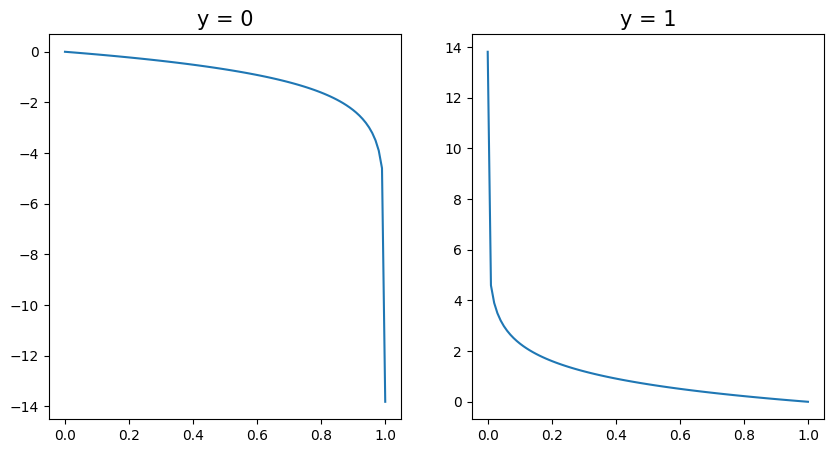

In [1]:
import numpy as np
import matplotlib.pyplot as plt
eps = 1e-6
n_out = np.linspace(0 + eps, 1 - eps, 100)

def cross_entropy(pred, y):
    return (1 - y)*np.log(1 - pred) - y*np.log(pred)

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)

for y, ax in enumerate(axes):
    ax.plot(n_out, cross_entropy(n_out, y))
    ax.set_title(f"y = {y}", fontsize=15)



### Problem 5.3∗ Suppose we want to build a model that predicts the direction y in radians of the prevailing wind based on local measurements of barometric pressure x. A suitable distribution over circular domains is the von Mises distribution (figure 5.13): P r(y|µ, κ) = exp κ cos[y − µ] 2π · Bessel0[κ],where µ is a measure of the mean direction and κ is a measure of concentration (i.e., the inverse of the variance). The term Bessel0[κ] is a modified Bessel function of the first kind of order 0. Use the recipe from section 5.2 to develop a loss function for learning the parameter µ of a model f[x, ϕ] to predict the most likely wind direction. Your solution should treat the concentration κ as constant. How would you perform inference?

In [2]:
from scipy.special import j0  # Bessel function of the first kind, order 0
# 1. Choose our distribution

def p_von_mises(y, mu, kappa):
    return np.exp(kappa * np.cos(y - mu)) / (2 * np.pi * j0(kappa))

# 2. Make a model
def model(x):
    return 2 * np.pi * x

# 3. compute the nll
def nll(y, mu, k):
    return -np.sum(np.log(p_von_mises(y, mu, k)))






Essentially, we train a model to predict mu from surface pressure x by minimizing the nll over the data y and the predicted mu, holding kappa constant.  
In this situation, inference is straightforward, as we just return the model prediction.

If we don't care about the uncertainty as a trainable parameter we can simplify the loss function by pushing the log through the von Mises distribution

\begin{align}
    \log (P_{vM}(y | \mu, \kappa)) &= \kappa cos(y - \mu) - \log (2\pi Bessel_0(\kappa)) \\    
\end{align}

And we can throw away the bessel term since we are not training our model on $\kappa$.

### Problem 5.4∗ Sometimes, the outputs y for input x are multimodal (figure 5.14a); there is more than one valid prediction for a given input. Here, we might use a weighted sum of normal components as the distribution over the output. This is known as a mixture of Gaussians model. For example, a mixture of two Gaussians has parameters θ = {λ, µ1, σ12 1, µ2, σ22}: P r(y|λ, µ1, µ2, σ21, σ22) = λp2πσ21 exp −(y − µ1)22σ21 + 1 − λp2πσ22exp −(y − µ2)22σ22, (5.35) where λ ∈ [0, 1] controls the relative weight of the two components, which have means µ1, µ2and variances σ21, σ22, respectively. This model can represent a distribution with two peaks (figure 5.14b) or a distribution with one peak but a more complex shape (figure 5.14c).Use the recipe from section 5.2 to construct a loss function for training a model f[x, ϕ] that takes input x, has parameters ϕ, and predicts a mixture of two Gaussians. The loss should be based on I training data pairs {xi, yi}. What problems do you foresee when performing inference?

For each data point pair, we're going to get a pretty gross expression

\begin{align}
    L[\theta] = -\sum\limits_i \log (\lambda[x_i, \phi] P(y_i | \mu_1[x_i, \phi], \sigma_1[x_i, \phi]) + (1 - \lambda[x_i, \phi]) P(y_i | \mu_2[x_i, \phi], \sigma_2[x_i, \phi]))
\end{align}

Because log doesn't distribute over addition, theres going to be no easy way to get a nice expression for the loss, which in turn means we're going to have to sample from the model distribution to get the MAP estimate.  This is fine, just more expensive.  

### Problem 5.5 Consider extending the model from problem 5.3 to predict the wind direction using a mixture of two von Mises distributions. Write an expression for the likelihood P r(y|θ) for this model. How many outputs will the network need to produce?

\begin{align}
    \theta &= \{\lambda, \mu_1, \mu_2\} \\
    P(y_i | \theta) &= \lambda[x_i, \phi] \frac{\exp[\kappa \cdot \cos[y_i - \mu_1[x_i, \phi]]]}{2\pi J_0[\kappa]} + (1 - \lambda[x_i, \phi])  \frac{\exp[\kappa \cdot \cos[y_i - \mu_2[x_i, \phi]]]}{2\pi J_0[\kappa]}
\end{align}

and has three outputs to produce.

### Problem 5.6 Consider building a model to predict the number of pedestrians y ∈ {0, 1, 2, . . .} that will pass a given point in the city in the next minute, based on data x that contains information about the time of day, the longitude and latitude, and the type of neighborhood. A suitable distribution for modeling counts is the Poisson distribution (figure 5.15). This has a single parameter λ > 0 called the rate that represents the mean of the distribution. The distribution has probability density function: P r(y = k) = λke−λk!. (5.36) Design a loss function for this model assuming we have access to I training pairs {xi, yi}.

The likelihood of an individual example would be

\begin{align}
    \theta &= \{ \lambda \} \\
    P(y_i | \theta) &= \frac{\lambda[x_i, \phi]^{y_i}e^{-\lambda[x_i, \phi]]}}{y_i!} \\
\end{align}

So our loss is 

\begin{align}
    L[\phi] &= - \sum\limits_i \log\left[\frac{\lambda[x_i, \phi]^{y_i}e^{-\lambda[x_i, \phi]]}}{y_i!}\right] \\    
\end{align}

### Problem 5.7 Consider a multivariate regression problem where we predict ten outputs, so y ∈ R10, and model each with an independent normal distribution where the means µd are predicted by the network, and variances σ2 are constant. Write an expression for the likelihood P r(y|f[x, ϕ]). Show that minimizing the negative log-likelihood of this model is still equivalent to minimizing a sum of squared terms if we don’t estimate the variance σ2

We'd do this with a multivariate Gaussian distribution

\begin{align}
    \theta &= \{ \mathbf{\mu} \} \\
    P(\mathbf{y}_i | \theta) &= \frac{1}{\sqrt{(2\pi)^{10} |\Sigma |}} \exp\left[ -\frac{1}{2}(\mathbf{y}_i - \mathbf{\mu}[\mathbf{x_i}, \phi])^T \Sigma^-1 (\mathbf{y}_i - \mathbf{\mu}[\mathbf{x_i}, \phi])\right]
\end{align}

Which produces a loss (after throwing away some terms constant w/r/t minimization)

\begin{align}
    L[\phi] &= \sum\limits_i (\mathbf{y}_i - \mathbf{\mu}[\mathbf{x_i}, \phi])^T \Sigma^-1 (\mathbf{y}_i - \mathbf{\mu}[\mathbf{x_i}, \phi])
\end{align}

Assuming each output is independent means $\Sigma$ is diagonal and we can rewrite this as 

\begin{align}
    L[\phi] &= \sum\limits_i \sum\limits_j^{10} \frac{(y_{ij} - \mu_j[x_{ij}, \phi])^2}{\sigma_j^2} \\
    &\rightarrow \sum\limits_i \sum\limits_j^{10} (y_{ij} - \mu_j[x_{ijk}, \phi])^2\\
\end{align}

where $j$ ranges over the dimensions of the output.

### Problem 5.8∗ Construct a loss function for making multivariate predictions y ∈ R Do based on independent normal distributions with different variances σ2d for each dimension. Assume a heteroscedastic model so that both the means µd and variances σ2 d vary as a function of the data.

The likelihood for an individual example is the same as in 5.7, but we can no longer throw away the normalization term.  Let's first rewrite as a product of distributions (from independence)
\begin{align}
    \theta &= \{ \mu_j, \sigma_j \} \\
    P(\mathbf{y}_i | \theta) &= \prod\limits_j \frac{1}{\sqrt{2\pi \sigma_j^2}}  \exp\left[ -\frac{ y_{ij} - \mu_j}{2\sigma_j^2} \right]
\end{align}

Which produces the loss

\begin{align}
    L[\phi] &= -\sum\limits_i log\left[ \prod\limits_j \frac{1}{\sqrt{2\pi \sigma_j^2}}  \exp\left[ -\frac{ y_{ij} - \mu_j}{2\sigma_j^2} \right]\right] \\
    &= \sum\limits_i \sum\limits_j \pi \sigma_j^2 + \frac{(y_{ij} - \mu_j)^2}{\sigma_j^2}
\end{align}


### Problem 5.9∗ Consider a multivariate regression problem in which we predict the height of a person in meters and their weight in kilos from data x. Here, the units take quite different ranges. What problems do you see this causing? Propose two solutions to these problems.

Because the two outputs will come in very different units, the loss will pay more attention to one than the other.  Two approaches to this problem:

1. Predict a z-score for height and weight (ie standard deviations from some fixed mean).  This will put things in the same scale by definition.
2. Learn the scale of the data with an additional parameter for each output.

### Problem 5.10 Extend the model from problem 5.3 to predict both the wind direction and the wind speed and define the associated loss function.

If we assume wind direction and wind speed are independent conditioned on the predictors, then we can write a likelihood for a data point using a product of two distributions. We'll keep the von Mises distribution with constant concentration for direction $\psi$ and use a gamma distribution for wind speed $v$, giving us:

\begin{align}
    \theta &= \{\mu, \alpha, \beta\} \\
    P(\psi_i, v_i | \theta) &= \frac{\exp[\kappa \cdot \cos[\psi_i - \mu]]}{2\pi J_0[\kappa]} \frac{\beta^{\alpha}}{\Gamma[\alpha]}v_i^{\alpha-1}e^{-\beta v_i}
\end{align}

yielding the likelihood (dropping irrelevant terms)

\begin{align}
    L[\phi] = - \sum\limits_i \kappa \cdot \cos[\psi_i - \mu[x_i, \phi]]] + \log\left[\frac{\beta[x_i, \phi]^{\alpha[x_i, \phi]}}{\Gamma[\alpha[x_i, \phi]]}v_i^{\alpha[x_i, \phi]-1}e^{-\beta[x_i, \phi] v_i}\right] \\
    = - \sum\limits_i \kappa \cdot \cos[\psi_i - \mu[x_i, \phi]]] + \alpha[x_i, \phi]\log[\beta[x_i, \phi]] - \log[\Gamma[\alpha[x_i, \phi]]] + (\alpha[x_i, \phi] - 1) \log[v_i] - \beta[x_i, \phi]v_i
\end{align}

Which sucks, but is fine, I guess